# Continuous Time 2D Model

We model the example of short-lived temperature sensors on the torus $[0,1]^2$ with identified edges in continuous time, using a combination of a queueing model and point process. Throughout the setup of the model, fix a time $T;$ for each time $t \in [0,T]$ the set of sensors $S_t$ at time $t$ is a set of locations on $\mathbb{R}^2,$ where $|S_t|$ is a random variable, and $S_t(i),$ the location of the $i$th sensor is uniformly sampled from the uniform measure on $[0,1]^2$.

Perhaps the easiest way to set up the model is via a (FIFO) queueing model, or birth-death process representing the sensors:

- We start with $L_0$ number of sensors, each sampled uniformly from the sphere. 
- Sensors are added to the queue every so often, again sampled uniformly from the sphere. 
- Independently of the creation of new sensors, sensors break down at a perhaps different rate, and leave the queue.

We can model the time between consecutive joining/ exiting of the queue by exponential distributions.

## Noise via isometries

We add random noise into the process that perturbs the system by isometries of the torus: in this case we add random time varying translation.


## Queueing Model Implementation
Consider a queueing model whose initial length is $L_0,$ the number of initial sensors we begin with. We assume that the queue processes sensors (physically: sensors break down) in a random time $\sim \text{Exp}(\lambda_1),$ and sensors join the queue with interarrival times distributed according to $\text{Exp}(\lambda_2),$ which are independent of the times it takes for the queue to process the input.

We can simulate this queue in the following way. For a given fixed time $t \in [0,T],$ by the memoryless property of exponential distributions, the time until a sensor leaves the queue is still $X_1 \sim \text{Exp}(\lambda_1)$ and the interarrival time is still distributed according to $X_2 \text{Exp}(\lambda_2).$ Now, the time until one of these two actions occurs is a random variable $Z = \min(X_1,X_2) \sim \text{Exp}(\lambda_1+\lambda_2)$ (which can be checked). Now the probability that a sensor joins the queue first is $\mathbb{P}(X_1 > X_2) = \frac{\lambda_1}{\lambda_1 + \lambda_2},$ and one minus that for the probability that a sensor breaks and leaves the queue. We can then model the process by waiting $\text{Exp}(\lambda_1+\lambda_2)$ amount of time, and with probability $\frac{\lambda_1}{\lambda_1 + \lambda_2},$ adding a new sensor to the queue, or otherwise removing the oldest sensor from the queue.

## Dynamic Network Analysis
The continuous time model allows us to subsample as finely as we want. We keep track of the birth/death of the sensors in an interval tree; for any $t \in [0,T]$ we query the interval tree for the set of points that are present on the sphere at that time, and then create a dynamic network via the delaunay construction, assigining node values via some observation function representing temperature, or another desired quantity, and the edge weights by distance on the sphere.

In [1]:
from __future__ import division
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import squareform
import importlib
import scipy.spatial as sp

## Load in sphere code
import tdadynamicnetworks.examples.PlaneExample as plane
import tdadynamicnetworks.examples.ContinuousTimeSensorModel as ctsm

## Load in d.n. analysis code
import tdadynamicnetworks.graph_fns as gf
import tdadynamicnetworks.persistence_fns as pf
import tdadynamicnetworks.sliding_window_fns as sw
from ripser import ripser
from persim import plot_diagrams
from sklearn import manifold

from matplotlib.lines import Line2D
import time 

In [2]:
## Setup Sensor Lifetimes 
max_lifetime = 4
seed = 25

T = 1
obsfn = lambda t, p: plane.nonstationary_periodic_plane_random_cos_series(t,p,T, seed = seed) # add some sort of isometry.

lambda1 = 50
lambda2 = lambda1

start = time.time()
sensor_lifetimes = ctsm.get_sensor_lifetimes(1000, max_lifetime, lambda1, lambda2, manifold = 'plane', seed = 17)

end = time.time()
print("Sampling Sensor Lifetimes", end - start) 

Sampling Sensor Lifetimes 1.833928108215332


In [21]:
## Create the Dynamic Network
fac = 10
step_size = 0.05/fac
ts = np.arange(0,max_lifetime,step_size) 

start = time.time()
(node_wts,edge_wts, allpoints) = ctsm.sample_dynamic_geometric_graph(sensor_lifetimes, ts,
                                                                     obsfn = obsfn, manifold = 'torus')
end = time.time()
print("Sampling Dynamic Network", end - start) 

Sampling Dynamic Network 803.5379118919373


In [22]:
import multiprocessing as mp
from joblib import Parallel, delayed

start = time.time()
filtration_matrix = list(map(lambda n, e: pf.get_filtration(n, e), node_wts, edge_wts))
end = time.time()
print("Converting to filtration matrices", end - start) 

start = time.time()
num_cores = mp.cpu_count() - 4
barcodes = Parallel(n_jobs = num_cores)(delayed(pf.get_rips_complex)(filt) for filt in filtration_matrix)
end = time.time()
print("Computing barcodes", end - start) 

start = time.time()
bn_dist_matrix = pf.get_bottleneck_dist_matrix(barcodes); # add parallel; add suppress output
end = time.time()
print("Computing bottleneck", end - start) 

Converting to filtration matrices 88.44500994682312
Computing barcodes 195.6994686126709
Computing Row 0
Computing Row 1
Computing Row 2
Computing Row 3
Computing Row 4
Computing Row 5
Computing Row 6
Computing Row 7
Computing Row 8
Computing Row 9
Computing Row 10
Computing Row 11
Computing Row 12
Computing Row 13
Computing Row 14
Computing Row 15
Computing Row 16
Computing Row 17
Computing Row 18
Computing Row 19
Computing Row 20
Computing Row 21
Computing Row 22
Computing Row 23
Computing Row 24
Computing Row 25
Computing Row 26
Computing Row 27
Computing Row 28
Computing Row 29
Computing Row 30
Computing Row 31
Computing Row 32
Computing Row 33
Computing Row 34
Computing Row 35
Computing Row 36
Computing Row 37
Computing Row 38
Computing Row 39
Computing Row 40
Computing Row 41
Computing Row 42
Computing Row 43
Computing Row 44
Computing Row 45
Computing Row 46
Computing Row 47
Computing Row 48
Computing Row 49
Computing Row 50
Computing Row 51
Computing Row 52
Computing Row 53
Com

Computing Row 459
Computing Row 460
Computing Row 461
Computing Row 462
Computing Row 463
Computing Row 464
Computing Row 465
Computing Row 466
Computing Row 467
Computing Row 468
Computing Row 469
Computing Row 470
Computing Row 471
Computing Row 472
Computing Row 473
Computing Row 474
Computing Row 475
Computing Row 476
Computing Row 477
Computing Row 478
Computing Row 479
Computing Row 480
Computing Row 481
Computing Row 482
Computing Row 483
Computing Row 484
Computing Row 485
Computing Row 486
Computing Row 487
Computing Row 488
Computing Row 489
Computing Row 490
Computing Row 491
Computing Row 492
Computing Row 493
Computing Row 494
Computing Row 495
Computing Row 496
Computing Row 497
Computing Row 498
Computing Row 499
Computing Row 500
Computing Row 501
Computing Row 502
Computing Row 503
Computing Row 504
Computing Row 505
Computing Row 506
Computing Row 507
Computing Row 508
Computing Row 509
Computing Row 510
Computing Row 511
Computing Row 512
Computing Row 513
Computing 

In [23]:
wl = 2.0*T
d = 20
swe = sw.sliding_window(range(len(barcodes)), d=d, tau= int(wl/(d*step_size)),
                                    max_index = int(10.*T/step_size) )

print("Number of points in SW Embedding:", len(swe))
sw_dist_matrix = sw.sw_distance_matrix(swe, bn_dist_matrix)
#sw_dist_matrix /= np.max(sw_dist_matrix)

Number of points in SW Embedding: 420


In [16]:
print('sampling 0.02')
bn_dist_matrix[:5,:5]

sampling 0.02


array([[0.        , 0.03345287, 0.04615456, 0.04715598, 0.11586487],
       [0.03345287, 0.        , 0.03258374, 0.04715598, 0.11586487],
       [0.04615456, 0.03258374, 0.        , 0.03631222, 0.11586487],
       [0.04715598, 0.04715598, 0.03631222, 0.        , 0.11586487],
       [0.11586487, 0.11586487, 0.11586487, 0.11586487, 0.        ]])

In [13]:
print('sampling 0.02')
print(np.max(sw_dist_matrix))
sw_dist_matrix[:5,:5]

sampling 0.02
3.8205821180886215


array([[0.        , 0.59882333, 1.06631687, 1.4448616 , 1.95475344],
       [0.59882333, 0.        , 0.55841578, 0.97041744, 1.37746985],
       [1.06631687, 0.55841578, 0.        , 0.60941245, 1.05628099],
       [1.4448616 , 0.97041744, 0.60941245, 0.        , 0.69361255],
       [1.95475344, 1.37746985, 1.05628099, 0.69361255, 0.        ]])

In [17]:
print('sampling 0.01')
bn_dist_matrix[:10,:10]

sampling 0.01


array([[0.        , 0.02978486, 0.06174171, 0.07336311, 0.09599859,
        0.12940758, 0.16642886, 0.20695925, 0.25088018, 0.29805797],
       [0.02978486, 0.        , 0.03195685, 0.06590596, 0.07775629,
        0.11116529, 0.14818656, 0.18871695, 0.23263788, 0.27981567],
       [0.06174171, 0.03195685, 0.        , 0.03394911, 0.06970325,
        0.08905548, 0.12607676, 0.16660714, 0.21052808, 0.25770587],
       [0.07336311, 0.06590596, 0.03394911, 0.        , 0.03575414,
        0.07311949, 0.10806268, 0.14066976, 0.1845907 , 0.23176849],
       [0.09599859, 0.07775629, 0.06970325, 0.03575414, 0.        ,
        0.03736535, 0.10806268, 0.11096066, 0.1548816 , 0.20205939],
       [0.12940758, 0.11116529, 0.08905548, 0.07311949, 0.03736535,
        0.        , 0.10806268, 0.10554886, 0.1214726 , 0.16865039],
       [0.16642886, 0.14818656, 0.12607676, 0.10806268, 0.10806268,
        0.10806268, 0.        , 0.04053038, 0.08445132, 0.13162911],
       [0.20695925, 0.18871695, 0.1666071

In [19]:
print('sampling 0.01')
print(np.max(sw_dist_matrix))
sw_dist_matrix[:10,:10]

sampling 0.01
3.8205821180886215


array([[0.        , 0.32540291, 0.59882333, 0.84633737, 1.06631687,
        1.26297678, 1.4448616 , 1.67638578, 1.95475344, 2.05571635],
       [0.32540291, 0.        , 0.31682074, 0.58057401, 0.80036619,
        1.01673342, 1.20939929, 1.40309797, 1.59145733, 1.78264416],
       [0.59882333, 0.31682074, 0.        , 0.38587824, 0.55841578,
        0.77597497, 0.97041744, 1.19049567, 1.37746985, 1.58271127],
       [0.84633737, 0.58057401, 0.38587824, 0.        , 0.29932714,
        0.55540755, 0.76037304, 1.01983218, 1.21928695, 1.42144269],
       [1.06631687, 0.80036619, 0.55841578, 0.29932714, 0.        ,
        0.38278578, 0.60941245, 0.8943362 , 1.05628099, 1.25192197],
       [1.26297678, 1.01673342, 0.77597497, 0.55540755, 0.38278578,
        0.        , 0.33557375, 0.7124944 , 0.86964226, 1.06149424],
       [1.4448616 , 1.20939929, 0.97041744, 0.76037304, 0.60941245,
        0.33557375, 0.        , 0.5735132 , 0.69361255, 0.8811488 ],
       [1.67638578, 1.40309797, 1.1904956

## Plotting

Text(0.5, 1.0, 'Sliding Window Distance Matrix')

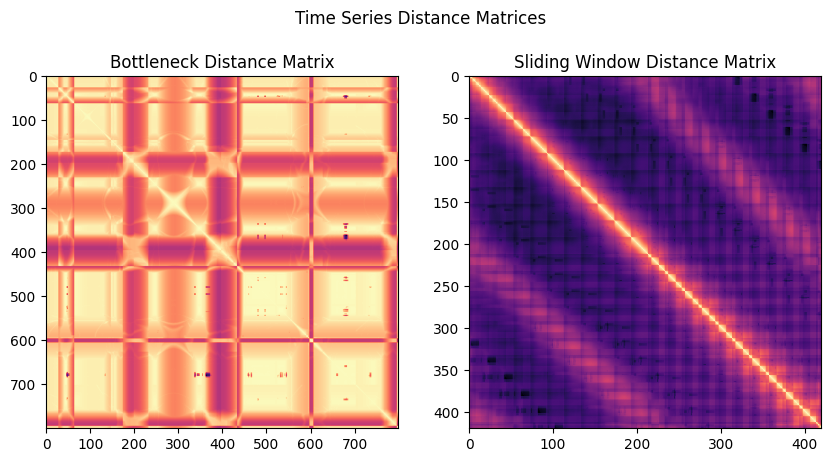

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
fig.suptitle('Time Series Distance Matrices')
ax1.imshow(bn_dist_matrix, cmap='magma_r')
ax1.set_title('Bottleneck Distance Matrix')
ax2.imshow(sw_dist_matrix, cmap='magma_r')
ax2.set_title('Sliding Window Distance Matrix')
# what's the period of the persistence diagram time series? Is it half this?

(array([ 1570.,  1544.,  1726.,  5682.,  7326., 19108., 33538., 64930.,
        40152.,   824.]),
 array([0.        , 0.30528743, 0.61057487, 0.9158623 , 1.22114973,
        1.52643717, 1.8317246 , 2.13701204, 2.44229947, 2.7475869 ,
        3.05287434]),
 <a list of 10 Patch objects>)

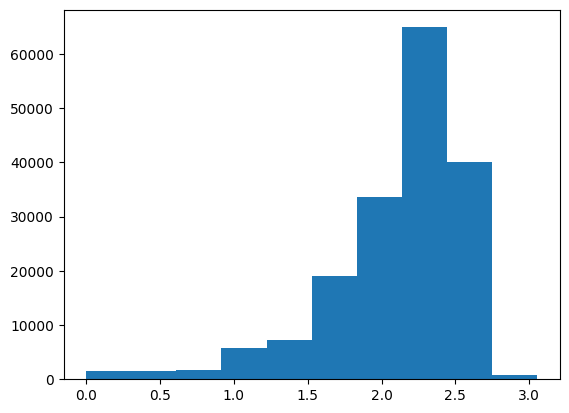

In [25]:
plt.hist(sw_dist_matrix.ravel())

(array([281.,  54.,  25.,   3.,  11.,   0.,   0.,   4.,  10.,  31.]),
 array([0.1295852 , 0.20640676, 0.28322833, 0.36004989, 0.43687146,
        0.51369302, 0.59051458, 0.66733615, 0.74415771, 0.82097928,
        0.89780084]),
 <a list of 10 Patch objects>)

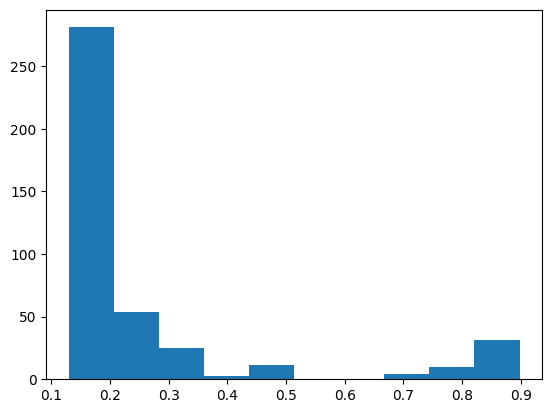

In [26]:
N = len(sw_dist_matrix)
k = 1
adj = [sw_dist_matrix[i,(i+k)%N] for i in range(N-k)]
plt.hist(adj)

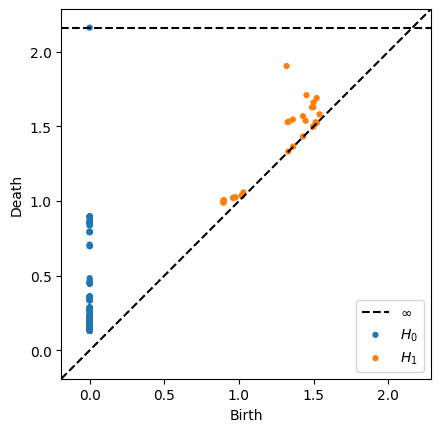

In [27]:
PDs = ripser(sw_dist_matrix, distance_matrix=True, maxdim=1, coeff=7)['dgms']
plot_diagrams(PDs)

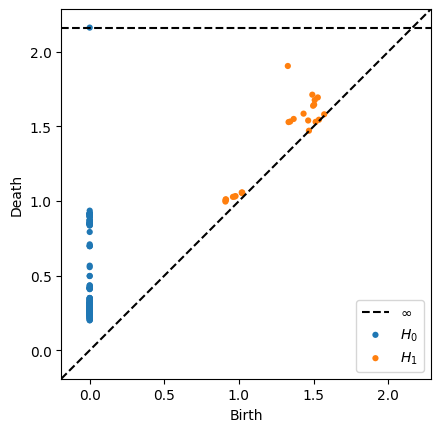

In [20]:
PDs = ripser(sw_dist_matrix, distance_matrix=True, maxdim=1, coeff=7)['dgms']
plot_diagrams(PDs)

In [10]:
min(PDs[1][:,0])

1.4471009969711304

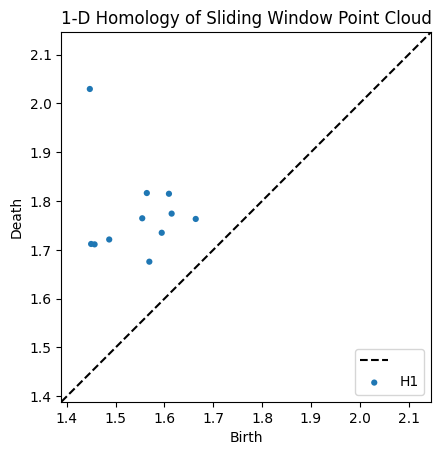

In [11]:
a = PDs[1]

plot_diagrams(PDs[1])
plt.title('1-D Homology of Sliding Window Point Cloud')
plt.legend([None,'H1'], loc = 4)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/manifold/_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


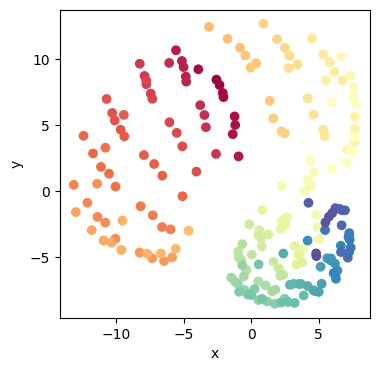

In [12]:
from sklearn.manifold import MDS

embedding = MDS(n_components=2)
X_transformed = embedding.fit_transform(sw_dist_matrix)
X_transformed.shape

fig = plt.figure(figsize = (4,4))

ax1 = fig.add_subplot(111)
ax1.set_ylabel('y')
ax1.set_xlabel('x')
ax1.scatter(X_transformed[:,0],X_transformed[:,1],
           c = np.linspace(0,1,X_transformed.shape[0]),
           cmap = plt.cm.Spectral)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams.update({'font.size': 15})

fig = plt.figure(figsize = (28,8))

ax1 = fig.add_subplot(143)
ax1.set_ylabel('y')
ax1.set_xlabel('x')
ax1.scatter(X_transformed[:,0],X_transformed[:,1],
           c = np.linspace(0,1,X_transformed.shape[0]),
           cmap = plt.cm.Spectral)
ax1.axes.xaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)
ax1.set_facecolor('black')
ax1.set_aspect('equal','box')
ax1.set_title('2D MDS of Sliding Window Point Cloud')

ax2 = fig.add_subplot(144)
ax2.scatter(PDs[1][:,0],PDs[1][:,1],s = 40, label = 'H1')
ax2.set_title('1-D Homology of Sliding Window Point Cloud')
ax2.legend(loc = 4)
ax2.set_aspect('equal','box')
lims = [
    np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
    np.max([ax2.get_xlim(), ax2.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax2.set_ylabel('Death')
ax2.set_xlabel('Birth')
ax2.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
ax2.plot(sa[-1,0],sa[-1,1],'ro', linewidth = 160)

ax3 = fig.add_subplot(141)
ax3.imshow(bn_dist_matrix)
ax3.set_title('Bottleneck Distance Matrix')
ax3.set_ylabel('y')
ax3.set_xlabel('x')

ax4 = fig.add_subplot(142)
ax4.imshow(sw_dist_matrix)
ax4.set_title('Sliding Window Distance Matrix')
ax4.set_ylabel('y')
ax4.set_xlabel('x')

plt.tight_layout()
#plt.savefig('nonstationary_torus_results_copy.pdf')

In [ ]:
from sklearn.manifold import MDS

embedding = MDS(n_components=3)
X_transformed = embedding.fit_transform(sw_dist_matrix)
X_transformed.shape

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_transformed[:,0],X_transformed[:,1],X_transformed[:,2],
           c = np.linspace(0,1,X_transformed.shape[0]),
           cmap = plt.cm.ocean)